In [1]:
# useful to autoreload the module without restarting the kernel
%load_ext autoreload
%autoreload 2

In [2]:
from mppi import InputFiles as I, Calculators as C, Datasets as D, Parsers as P, Utilities as U
from mppi.Calculators import Tools
from mppi.Datasets import PostProcessing as PP
from mppi.Utilities import Constants as Const
from mppi.Utilities import LatticeUtils as LL
import matplotlib.pyplot as plt
import numpy as np
import os, yaml

# Report of the Stanene results

This notebook collects the relevant results achieved for the systems. In this way we aim to plot and analyze the relevant data
without the whole procedure needed to compute them. This procedure is also needed to identify the results the have to be saved 
in order to be able to export and use the (relevant) data only.

## DFT Analysis

### KS evals and k-point sampling

In [4]:
data = P.PwParser('DFT_analysis/kpoints_60-nbnds_600.xml')
#data.get_gap()

Parse file : DFT_analysis/kpoints_60-nbnds_600.xml


number of kpoints = 331


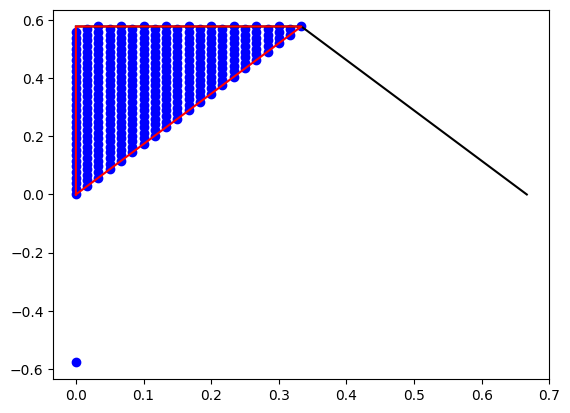

In [5]:
kp = data.kpoints # cartesian coordinates in units of 2\pi/alat

Gamma = np.array([0.,0.])
K = np.array([2./3.,0])
M = np.array([1./2.,1./(2*np.sqrt(3))])
Kp = np.array([1./3.,1./np.sqrt(3)])
Mp = np.array([0.,1./np.sqrt(3)])

BZ = [K, Kp, Mp]
print('number of kpoints = %s'%len(kp))
plt.plot(*np.column_stack(BZ),color='black')
IBZ = [Gamma,Kp, Mp,Gamma]
plt.plot(*np.column_stack(IBZ),color='red')
plt.scatter(kp[:,0],kp[:,1],c='blue')

### Band structure

In [8]:
bands_data = 'DFT_analysis/bands.save/data-file-schema.xml'

In [9]:
# we write the coordinates of the high symmetry points (using the tpiba_b type of pw) and we make usage of the function build_kpath
G = [0.,0.,0.]
Kp = [1./3.,1./np.sqrt(3),0.]
Mp = [0.,1./np.sqrt(3),0.]
high_sym = {'G':G,'K':Kp,'M':Mp} # useful to label the high-sym point on the path

bands = U.BandStructure.from_Pw(bands_data,high_sym_points=high_sym)

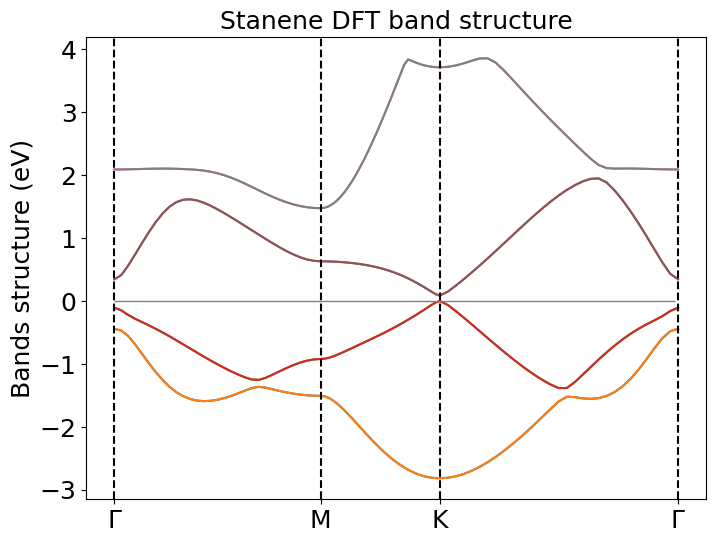

In [10]:
label_size = 18

fig, ax = plt.subplots(figsize=(8, 6))
#ax.set_ylim(-5,7)
bands.plot(plt,selection=[i for i in range(24,32)])
ax.hlines(0.,0.,1.57,linestyles='-',color='gray',linewidth=1)
ax.set_ylabel('Bands structure (eV)',size=label_size)
ax.set_title('Stanene DFT band structure',size=label_size)
ax.tick_params(axis='both', which='major', labelsize=label_size)

#plt.savefig(fname='Plot/band_structure.eps',format='eps',bbox_inches = "tight")

## GW Analysis

### Convergence Analysis

We collect the results of the convergence procedure. For this system only the convergence of the gap (at G and K) in terms
of the number of kpoints has been performed. The choice of the other parameters has been performed using the previous
computational analysis, plots of this procedure are reported in the GW_Analysis notebook

In [13]:
ksamplings = {'18x18x1': {'folder':'kpoints_18-nbnds_600','K_index':37,'G_index':1},
             '60x60x1': {'folder':'kpoints_60-nbnds_600','K_index':331,'G_index':1},
             '72x72x1': {'folder':'kpoints_72-nbnds_600','K_index':469,'G_index':1},
            }

In [15]:
start_band,stop_band = 28,29

gap_G, gap_K = [],[]
for kpoints in ksamplings:
    file_G = os.path.join('MB_analysis',ksamplings[kpoints]['folder'],'pp-G-kpoints_%s'%kpoints,'o-pp-G-kpoints_%s.qp'%kpoints)
    file_K = os.path.join('MB_analysis',ksamplings[kpoints]['folder'],'pp-K-kpoints_%s'%kpoints,'o-pp-K-kpoints_%s.qp'%kpoints)
    data_G = P.YamboOutputParser.from_file(file_G,extendOut=True,verbose=False)
    data_K = P.YamboOutputParser.from_file(file_K,extendOut=True,verbose=False)
    gap_G.append(data_G.get_gap(k_full=ksamplings[kpoints]['G_index'],band_full=start_band,verbose=False))
    gap_K.append(data_K.get_gap(k_full=ksamplings[kpoints]['K_index'],band_full=start_band,verbose=False))
gap_G,gap_K

([np.float64(0.7944530000000001), np.float64(0.883352), np.float64(0.885593)],
 [np.float64(0.19117399999999996),
  np.float64(0.18749399999999994),
  np.float64(0.187002)])

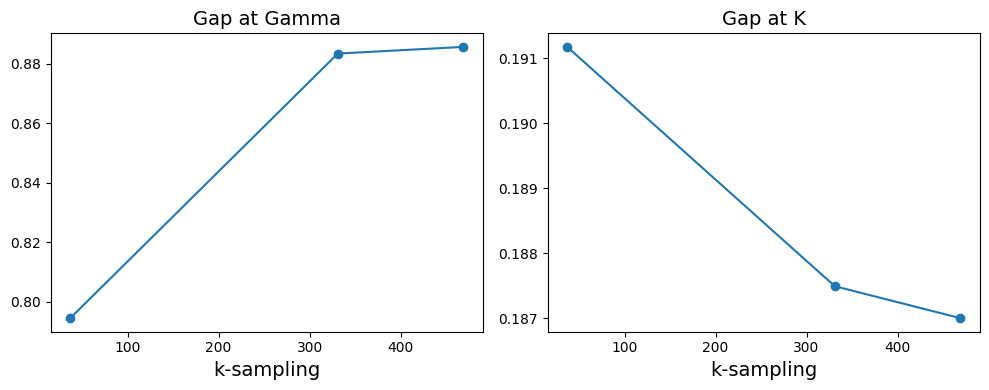

In [16]:
kpoints =  [37,331,469]
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
axes[0].plot(kpoints,gap_G)
axes[0].scatter(kpoints,gap_G)
axes[0].set_title('Gap at Gamma',size=14)
axes[0].set_xlabel('k-sampling',size=14)
axes[1].plot(kpoints, gap_K)
axes[1].scatter(kpoints,gap_K)
axes[1].set_xlabel('k-sampling',size=14)
axes[1].set_title('Gap at K',size=14)
fig.tight_layout()

We extrapolate the value of the gap at K using an exponential fit

In [17]:
import scipy

In [18]:
def monoExp(x, m, t, b):
    return m * np.exp(-t * x) + b

The asymptotic gap is equal to  0.187  eV


C:\Users\Marco\AppData\Local\Temp\ipykernel_25888\2896392034.py:4: OptimizeWarning: Covariance of the parameters could not be estimated
  params, cv = scipy.optimize.curve_fit(monoExp, xs, gap_K, p0)


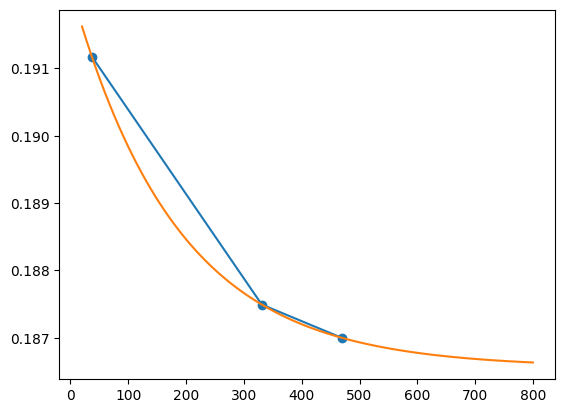

In [19]:
xs = np.array(kpoints)
xfit = np.linspace(20,800,100)
p0 = [1,0.01,0.1]
params, cv = scipy.optimize.curve_fit(monoExp, xs, gap_K, p0)
m, t, b = params
fit = monoExp(xfit, m, t, b)
plt.plot(kpoints,gap_K)
plt.scatter(kpoints,gap_K)
plt.plot(xfit,fit)
print('The asymptotic gap is equal to ',np.round(b,decimals=3),' eV')

### Band Structure

In [20]:
Gamma = np.array([0.,0.,0.])
Kp = np.array([1./3.,1./np.sqrt(3),0.])
#Mp = np.array([0.,1./np.sqrt(3),0.])
Mp = np.array([0.,0.55810523,0.]) # use this approximated value beacuse computation at M is lacking for symmetry reasons

high_sym = {'G':Gamma,'K':Kp,'M':Mp} # in cartesian coordinates
high_sym

{'G': array([0., 0., 0.]),
 'K': array([0.33333333, 0.57735027, 0.        ]),
 'M': array([0.        , 0.55810523, 0.        ])}

In [21]:
from mppi.Utilities.Utils import file_parser

In [23]:
kpoints_sampled = file_parser('MB_analysis/kpoints_60-nbnds_600/kpoints_sampled.log').T
data_dft = file_parser('MB_analysis/kpoints_60-nbnds_600/data_dft.log')
data_gw = file_parser('MB_analysis/kpoints_60-nbnds_600/data_gw.log')

In [24]:
kpoints_sampled.shape,data_dft.shape,data_gw.shape

((60, 3), (8, 60), (8, 60))

In [25]:
bands_dft = U.BandStructure(kpoints_sampled,data_dft,high_sym_points=high_sym) 
bands_gw = U.BandStructure(kpoints_sampled,data_gw-max(data_gw[3]),high_sym_points=high_sym)

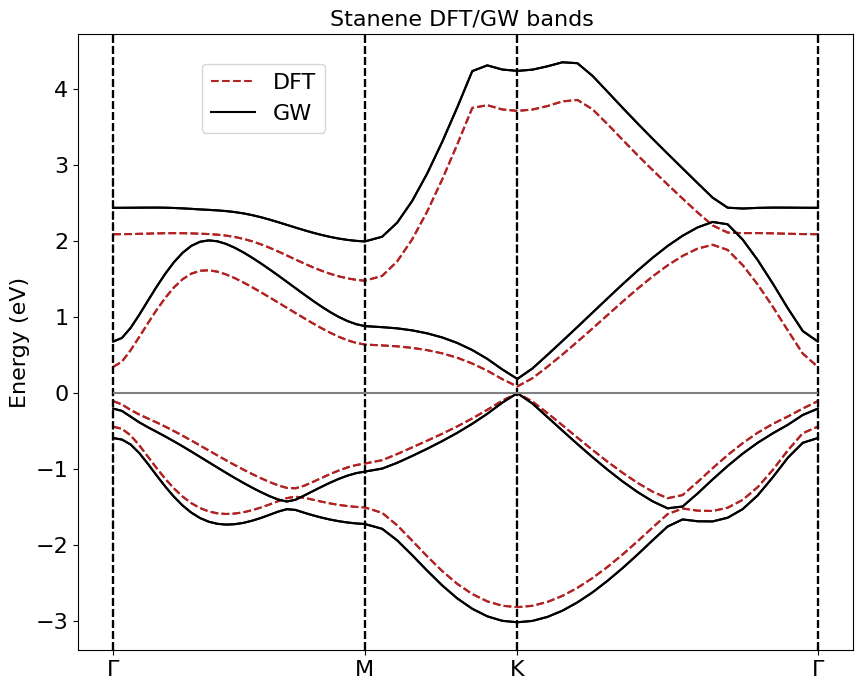

In [26]:
fig, ax1 = plt.subplots(figsize=(10,8))
bands_dft.plot(plt,axes=ax1,selection=[0],linestyle='--',label='DFT',c='firebrick')
bands_dft.plot(plt,axes=ax1,selection=[1,2,3,4,5,6,7],linestyle='--',c='firebrick')
bands_gw.plot(plt,axes=ax1,selection=[0],linestyle='-',label='GW',c='black')
bands_gw.plot(plt,axes=ax1,selection=[1,2,3,4,5,6,7],linestyle='-',c='black')
ax1.hlines(0.,0.,max(bands_dft.kpath),linestyles='-',color='gray')
#ax1.set_ylim(-0.5,0.5)
ax1.set_ylabel('Energy (eV)',size=16)
ax1.set_title('Stanene DFT/GW bands ',size=16)
ax1.legend(loc=(0.16,0.84),fontsize=16,frameon=True)
ax1.tick_params(axis='both', which='major', labelsize=16)

0.187494


(-0.4, 0.6)

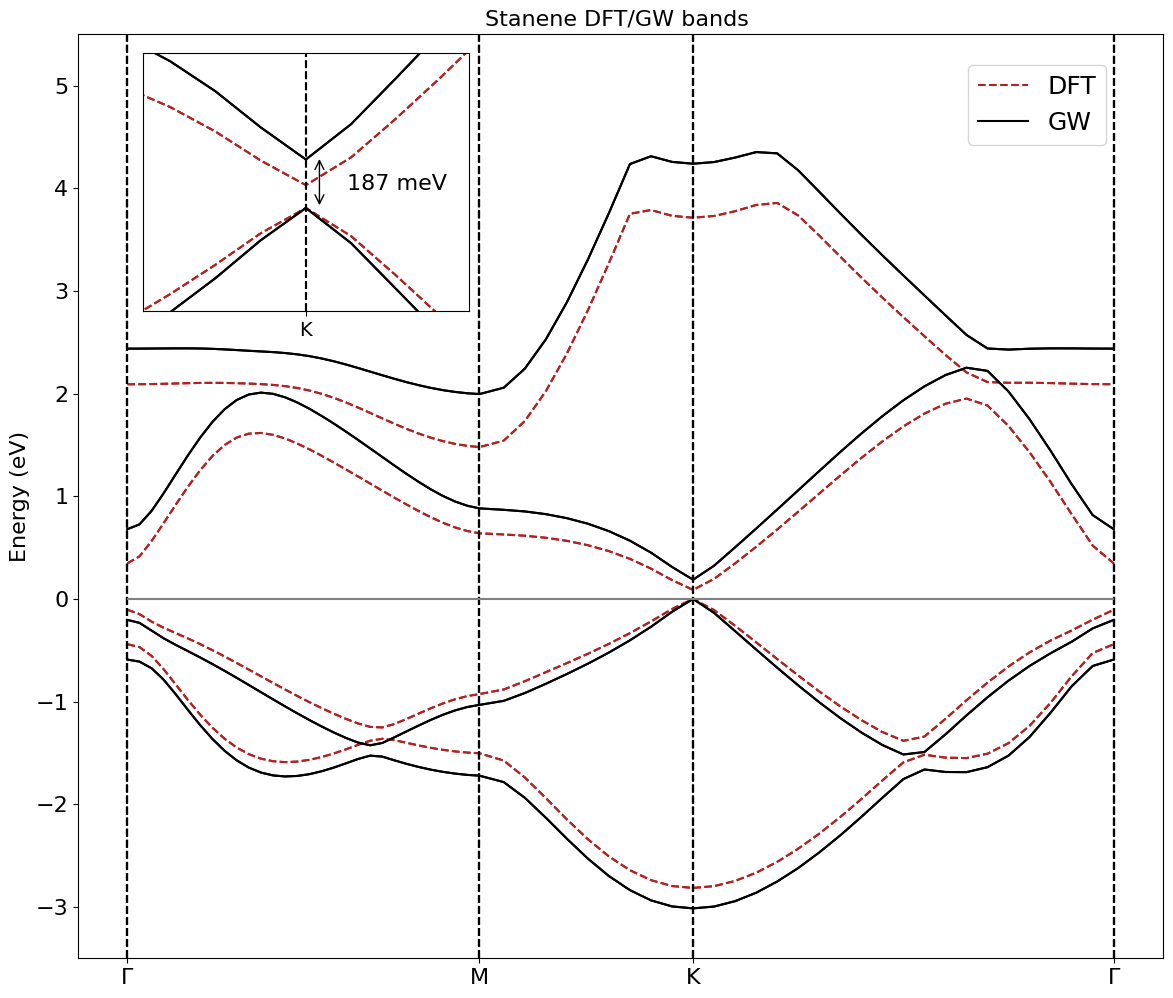

In [28]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

K_position = bands_dft.get_high_sym_positions()[1][2]
shift = 0.12
gap = min(bands_gw.bands[4]) - max(bands_gw.bands[3])
print(gap)

fig, ax1 = plt.subplots(figsize=(14,12))

# --- bands ---
bands_dft.plot(plt, axes=ax1, selection=[0], linestyle='--', label='DFT', c='firebrick')
bands_dft.plot(plt, axes=ax1, selection=[1,2,3,4,5,6,7], linestyle='--', c='firebrick')
bands_gw.plot(plt, axes=ax1, selection=[0], linestyle='-', label='GW', c='black')
bands_gw.plot(plt, axes=ax1, selection=[1,2,3,4,5,6,7], linestyle='-', c='black')

ax1.hlines(0., 0., max(bands_dft.kpath), linestyles='-', color='gray')
ax1.set_ylim(-3.5,5.5)
ax1.set_ylabel('Energy (eV)', size=16)
ax1.set_title('Stanene DFT/GW bands ', size=16)
ax1.legend(loc=(0.82, 0.88), fontsize=18, frameon=True)
ax1.tick_params(axis='both', which='major', labelsize=16)

ax2 = inset_axes(ax1, width="30%", height="28%", 
                 bbox_to_anchor=(0.06, -0.02, 1, 1),
                 bbox_transform=ax1.transAxes,
                 loc="upper left", borderpad=0)

# bands inside inset
bands_dft.plot(plt, axes=ax2, selection=[2,3,4,5], linestyle='--', c='firebrick')
bands_gw.plot(plt, axes=ax2, selection=[2,3,4,5], linestyle='-', c='black')

# annotation
ax2.annotate('', xy=(K_position+0.01, 0), 
             xytext=(K_position+0.01, 0.20),
             arrowprops=dict(arrowstyle='<->'), size=16)
ax2.text(K_position+0.03, 0.07, '187 meV', size=16)

# limits
ax2.set_yticks([])
ax2.set_xlim(K_position - shift, K_position + shift)
ax2.set_ylim(-0.4,0.6)

#plt.savefig(fname='Plot/Stanene-band_structure.jpg',format='jpeg',bbox_inches = "tight")

## OPTICS

We save the results of the BSE analysis for the various kpoints sampling considered.

In [4]:
ksamplings = {'18x18x1': {'folder':'kpoints_18-nbnds_600','K_index':37,'G_index':1},
             '60x60x1': {'folder':'kpoints_60-nbnds_600','K_index':331,'G_index':1},
             '72x72x1': {'folder':'kpoints_72-nbnds_600','K_index':469,'G_index':1},
            }

start_band,stop_band = 28,29

for kpoints in ksamplings:
    run_dir=os.path.join('MB_analysis',ksamplings[kpoints]['folder'])
    file = os.path.join(run_dir,'pp-K-kpoints_%s'%kpoints,'o-pp-K-kpoints_%s.qp'%kpoints)
    data = P.YamboOutputParser.from_file(file,verbose=False)
    ksamplings[kpoints]['gw_gap'] = data.get_gap(k_full=ksamplings[kpoints]['K_index'],band_full=start_band,verbose=False)
#ksamplings

In [5]:
alpha_data = []
exc_data = []
for kpoint in ksamplings:
    alpha_file = os.path.join('MB_analysis',ksamplings[kpoint]['folder'],
                        'abs-bse-bsengblk_3.0-bands_27-30-kpoints_%s'%kpoint,
                        'o-abs-bse-bsengblk_3.0-bands_27-30-kpoints_%s.alpha_q1_slepc_bse'%kpoint)
    exc_file = os.path.join('MB_analysis',ksamplings[kpoint]['folder'],
                        'abs-bse-bsengblk_3.0-bands_27-30-kpoints_%s'%kpoint,
                        'o-abs-bse-bsengblk_3.0-bands_27-30-kpoints_%s.Esort_q1_slepc_bse'%kpoint)
    alpha_data.append(P.YamboOutputParser.from_file(alpha_file,verbose=False))
    exc_data.append(P.YamboOutputParser.from_file(exc_file,verbose=False))

In [6]:
kpoints = [k for k in ksamplings]
exc_ind = 0 # index of the excitation. 0 = first excitation energy
excitations = []
for ind in range(len(kpoints)):
    excitations.append(exc_data[ind]['Esort_q1_slepc_bse']['energy'][exc_ind])
#print(excitations)

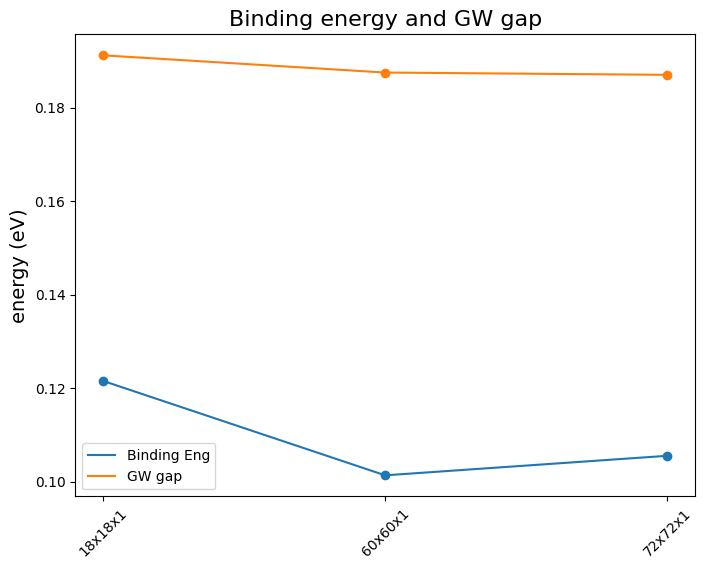

In [7]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(kpoints,excitations)
ax.plot(kpoints,excitations,label='Binding Eng')
gw_gaps = [ksamplings[k]['gw_gap'] for k in ksamplings]
ax.scatter(kpoints,gw_gaps)
ax.plot(kpoints,gw_gaps,label='GW gap')
labels = list(ksamplings.keys())
plt.xticks(np.arange(len(kpoints)), kpoints, rotation=45,size=10)
ax.set_title('Binding energy and GW gap',size=16)
ax.set_ylabel('energy (eV)',size=14)
ax.legend()
#ax.set_ylim(0.42,0.55)

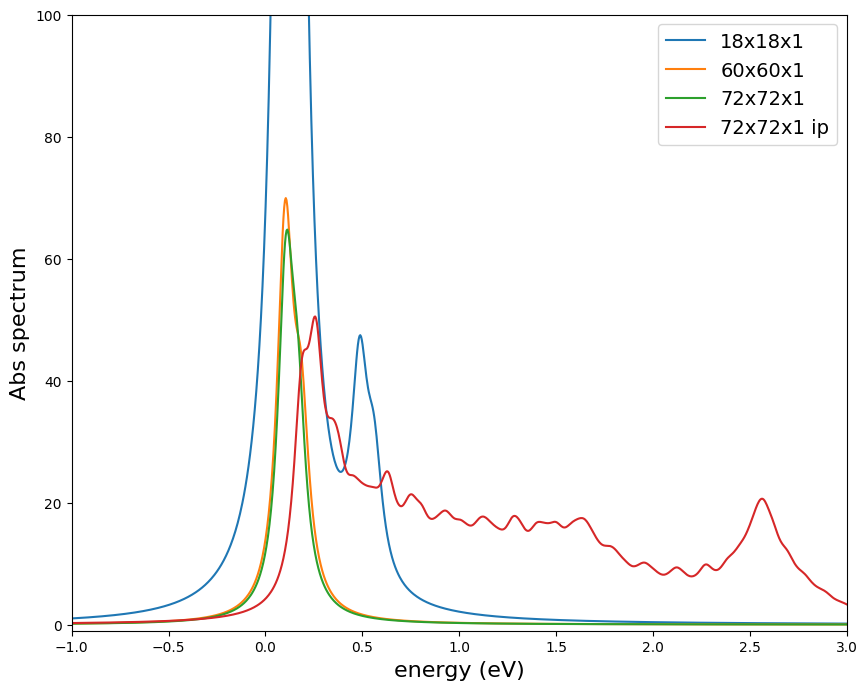

In [8]:
fig, ax = plt.subplots(figsize=(10, 8))

for ind in range(len(kpoints)):
    data = alpha_data[ind]['alpha_q1_slepc_bse']
    energy = data['energy']
    alpha_im = data['alpha_imag']
    ax.plot(energy,alpha_im,label=kpoints[ind])
alpha_o_im = alpha_data[-1]['alpha_q1_slepc_bse']['alpha_o_imag']
ax.plot(energy,alpha_o_im,label='72x72x1 ip') 
ax.set_xlim(-1,3)
ax.set_ylim(-1,100)
ax.set_ylabel('Abs spectrum',size=16)
ax.set_xlabel('energy (eV)',size=16)
ax.legend(fontsize=14)

We also extend the bse band range to 27-40 and compute the asbsorption spectrum using the Haydock method (for the 60x60x1 kpoints sampling)

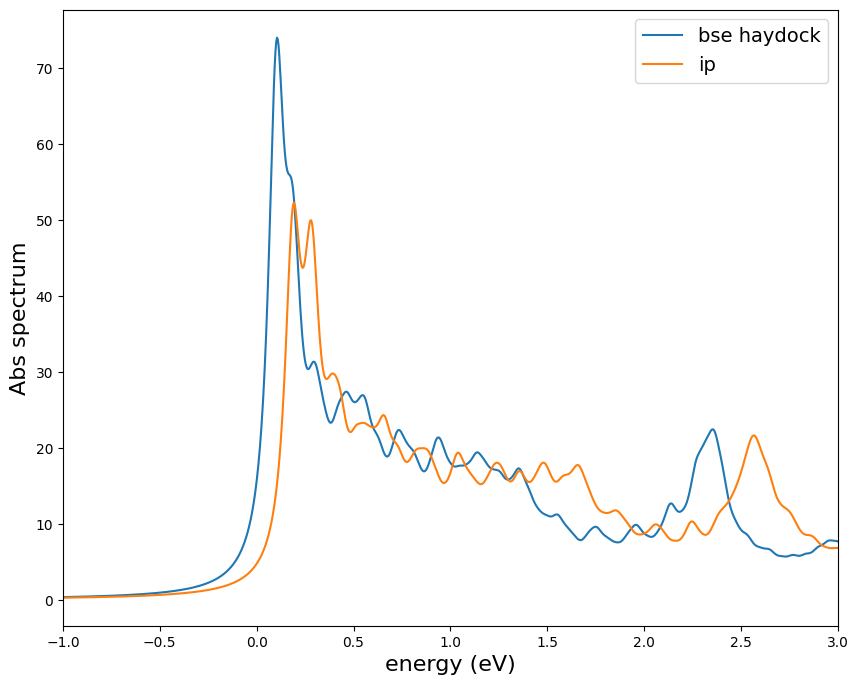

In [12]:
alpha_file = 'MB_analysis/kpoints_60-nbnds_600/abs-bse-bsengblk_3.0-bands_27-40/o-abs-bse-bsengblk_3.0-bands_27-40.alpha_q1_haydock_bse'
data = P.YamboOutputParser.from_file(alpha_file,verbose=False)

fig, ax = plt.subplots(figsize=(10, 8))

data = data['alpha_q1_haydock_bse']
energy = data['energy']
eps_im = data['alpha_imag']
ax.plot(energy,eps_im,label='bse haydock')
eps_o_im = data['alpha_o_imag']
ax.plot(energy,eps_o_im,label='ip') 
#ax.vlines(ksamplings[kpoints]['gw_gap'],-1,120,linestyles='--',color='red',linewidth=2)
ax.set_xlim(-1,3)
#ax.set_ylim(-1,200)
ax.set_ylabel('Abs spectrum',size=16)
ax.set_xlabel('energy (eV)',size=16)
ax.legend(fontsize=14)